# Combined Method: kNN and graph filtering
We first experiment with different adjacency matrices to see which ones give feasible ingredient suggestions after graph filtering. Then, we combine ingredient suggestion (via graph filtering) and replacement (via kNN) to see how the suggestions change as you add and remove ingredients.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pandas.io.json import json_normalize
import itertools
import networkx as nx

In [2]:
#Load lists of ingredients
ingredient_list = np.load('../data/Ingredient_List_USDA_Nutrition_Info.npy')
ingredient_list_full = np.load('../data/Ingredient_List.npy')

In [3]:
#Load recipe dataset
with open('../data/recipes_with_nutritional_info_fixed_qty.json') as json_file:
    data = json.load(json_file)
df = pd.DataFrame(data)

## Project recipe signal over ingredients graph

In [4]:
def createIngredientSignal(df,recipe_number,ingredient_list):
    """Generate a boolean signal from a recipe with 1's in the positions of the ingredients it contains and zeros elsewhere.
    Use the full ingredient name"""
    entry = df.iloc[recipe_number]
    recipe = entry['ingredients']
    ingredients = []
    for ingredient in recipe:
        ingredients += [ingredient['text']]
    indices = np.in1d(ingredient_list,ingredients)
    output = np.zeros(ingredient_list.shape)
    output[indices] = 1;
    return output

# test to project a signal over the ingredients graph
test_recipe = 1
ingr_signal = createIngredientSignal(df,test_recipe,ingredient_list)
print(ingr_signal)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0.]


## Useful functions

In [5]:
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    D = np.diag(np.sum(adjacency, 1)) # Degree matrix
    combinatorial = D - adjacency
    if normalize:
        D_norm = np.diag(np.clip(np.sum(adjacency, 1), 1, None)**(-1/2))
        return D_norm @ combinatorial @ D_norm
    else:
        return combinatorial

def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    return np.linalg.eigh(laplacian)

def GFT(signal, U):
    return U.T @ signal

def iGFT(fourier_coefficients, U):
    return U @ fourier_coefficients

def ideal_graph_filter(x: np.ndarray, spectral_response: np.ndarray, U):
    """Return a filtered signal."""
    x_gft = GFT(x,U)
    filter_gft = x_gft * spectral_response
    return iGFT(filter_gft,U)

## Graph filter: Label Propagation
Build a graph filter and smooth a recipe signal to get new ingredients recommendations (see further explanation in GraphFiltering.ipynb).

In [6]:
def filter_recipe(ingr_signal, adj_mat):
    '''Return a bandpass filtered version of the ingreident signal'''
    laplacian = compute_laplacian(adj_mat, normalize=True)
    lam, U = spectral_decomposition(laplacian)
    ideal_bp = np.ones(lam.shape)
    ideal_bp[lam >= 1] = 0  
    ideal_bp[lam <= 0.8] = 0
    x_bp = ideal_graph_filter(ingr_signal,ideal_bp,U)
    x_bp[ingr_signal > 0] = 0;    # prevent from outputing the same ingredients already in the recipe
    return x_bp

def predictNewIngredient(df, test_recipe, ingredient_list, adj_mat, remove=None, NB_RETURN=3):
    '''Suggest a new ingredient using graph filtering with an ideal bandpass filter.
    Ideally, the new ingredient should be the one that does not already exist in the recipe but has the highest weight after filtering
    You can optionally input idices of ingredients to remove.
    '''
    ingr_signal = createIngredientSignal(df,test_recipe,ingredient_list)
    if remove is not None:
        ingr_signal[remove] = 0
    x_bp = filter_recipe(ingr_signal, adj_mat)
    # return the most likely ingredients only
    new_ingr_ndx = x_bp.argsort()[-NB_RETURN:][::-1]
    new_ingredient = ingredient_list[new_ingr_ndx]
    recipe_name = df.iloc[test_recipe]['title']
    original_ingredients = ingredient_list[ingr_signal > 0]
    return new_ingredient, recipe_name, original_ingredients

### Test graph filter over different adjacency matrices

In [7]:
def first_word(w):
    """Return first word of a recipe"""
    nb = 2
    wd = ''
    i = 0
    w = w.split(',')
    while i < nb and i < len(w):
        wd += w[i]
        i = i + 1
    return wd
def first_word_list(lis):
    return ', '.join(np.vectorize(first_word)(lis))

def test(adj_mat, ingredient_list = ingredient_list, remove = 2):
    """Generate ingredient suggestions after ingredient removal via graph filtering"""
    test_recipes = [14, 19, 60, 82]
    for tr in test_recipes:
        suggested, recipe_name, original = predictNewIngredient(df, tr, ingredient_list, adj_mat)
        print("Recipe name: {}\nOriginal Ingredients: {}\nSuggested Ingredient: {}".format(
            recipe_name,
            original,
            first_word_list(suggested)))
        for i in range(remove):
            suggested, _, _ = predictNewIngredient(df, tr, ingredient_list, adj_mat, ingredient_list == original[i])
            print("After removing {}: {}".format(first_word(original[i]), first_word_list(suggested)))
        print()

#### Combined Normalized Adjacency Matrix (#7)

In [8]:
adj_mat_norm = np.load('../data/Adjacency_Matrix_7.npy')
test(adj_mat_norm)

Recipe name: Broccoli Chicken Casserole Recipe
Original Ingredients: ['broccoli, raw' 'cheese, cheddar'
 'chicken, broiler or fryers, breast, skinless, boneless, meat only, raw'
 'lemon juice, raw'
 'rice, white, long-grain, regular, unenriched, cooked without salt'
 'salad dressing, mayonnaise, regular'
 'soup, cream of chicken, canned, condensed']
Suggested Ingredient: spices onion powder, spices curry powder, sauce ready-to-serve
After removing broccoli raw: broccoli raw, spices onion powder, spices curry powder
After removing cheese cheddar: spices curry powder, sauce ready-to-serve, cheese blue

Recipe name: Mango Lassi
Original Ingredients: ['mango nectar, canned' 'spices, saffron' 'sugars, granulated'
 'water, bottled, generic' 'yogurt, greek, plain, nonfat']
Suggested Ingredient: grapes red or green (european type, pineapple raw, candies semisweet chocolate
After removing mango nectar canned: soy sauce made from soy (tamari), raisins seeded, apples raw
After removing spices saf

#### Addition Mean Adjacency Matrix (#10)

In [9]:
adj_mat_mean = np.load('../data/Adjacency_Matrix_10.npy')
test(adj_mat_mean)

Recipe name: Broccoli Chicken Casserole Recipe
Original Ingredients: ['broccoli, raw' 'cheese, cheddar'
 'chicken, broiler or fryers, breast, skinless, boneless, meat only, raw'
 'lemon juice, raw'
 'rice, white, long-grain, regular, unenriched, cooked without salt'
 'salad dressing, mayonnaise, regular'
 'soup, cream of chicken, canned, condensed']
Suggested Ingredient: grapes red or green (european type, soup chicken broth or bouillon, cauliflower raw
After removing broccoli raw: broccoli raw, grapes red or green (european type, shortening vegetable
After removing cheese cheddar: grapes red or green (european type, soup chicken broth or bouillon, cheese cheddar

Recipe name: Mango Lassi
Original Ingredients: ['mango nectar, canned' 'spices, saffron' 'sugars, granulated'
 'water, bottled, generic' 'yogurt, greek, plain, nonfat']
Suggested Ingredient: strawberries raw, leavening agents yeast, spices cardamom
After removing mango nectar canned: leavening agents yeast, strawberries raw, 

#### Combined Multiplication Adjacency Matrix (#11)

In [10]:
adj_mat_combined = np.load('../data/Adjacency_Matrix_11.npy')
test(adj_mat_combined)

Recipe name: Broccoli Chicken Casserole Recipe
Original Ingredients: ['broccoli, raw' 'cheese, cheddar'
 'chicken, broiler or fryers, breast, skinless, boneless, meat only, raw'
 'lemon juice, raw'
 'rice, white, long-grain, regular, unenriched, cooked without salt'
 'salad dressing, mayonnaise, regular'
 'soup, cream of chicken, canned, condensed']
Suggested Ingredient: mustard prepared, onions raw, water bottled
After removing broccoli raw: mustard prepared, onions raw, water bottled
After removing cheese cheddar: mustard prepared, onions raw, water bottled

Recipe name: Mango Lassi
Original Ingredients: ['mango nectar, canned' 'spices, saffron' 'sugars, granulated'
 'water, bottled, generic' 'yogurt, greek, plain, nonfat']
Suggested Ingredient: leavening agents yeast, lemon juice raw, mustard prepared
After removing mango nectar canned: leavening agents yeast, lemon juice raw, mustard prepared
After removing spices saffron: leavening agents yeast, lemon juice raw, mustard prepared



#### Sparsified Adjacency Matrix (#3)

In [11]:
adj_mat_sparsed = np.load('../data/Adjacency_Matrix_3.npy')
ingredients_to_remove = np.setdiff1d(ingredient_list_full, ingredient_list)
def find_ingredient_index(ingredient):
    return np.argwhere(ingredient_list_full == ingredient)[0,0]
ingredients_to_remove = np.vectorize(find_ingredient_index)(ingredients_to_remove)
adj_mat_sparsed = np.delete(adj_mat_sparsed, ingredients_to_remove, 0)
adj_mat_sparsed = np.delete(adj_mat_sparsed, ingredients_to_remove, 1)
test(adj_mat_sparsed, remove=1)

Recipe name: Broccoli Chicken Casserole Recipe
Original Ingredients: ['broccoli, raw' 'cheese, cheddar'
 'chicken, broiler or fryers, breast, skinless, boneless, meat only, raw'
 'lemon juice, raw'
 'rice, white, long-grain, regular, unenriched, cooked without salt'
 'salad dressing, mayonnaise, regular'
 'soup, cream of chicken, canned, condensed']
Suggested Ingredient: onions spring or scallions (includes tops and bulb), peppers sweet, mushrooms white
After removing broccoli raw: onions spring or scallions (includes tops and bulb), peppers sweet, mushrooms white

Recipe name: Mango Lassi
Original Ingredients: ['mango nectar, canned' 'spices, saffron' 'sugars, granulated'
 'water, bottled, generic' 'yogurt, greek, plain, nonfat']
Suggested Ingredient: beverages almond milk, peppers jalapeno, salad dressing ranch dressing
After removing mango nectar canned: beverages almond milk, salad dressing ranch dressing, peppers jalapeno

Recipe name: Cheesy POPcorn
Original Ingredients: ['butter

#### Combined Addition Adjacency Matrix (#9)

In [12]:
adj_mat_added = np.load('../data/Adjacency_Matrix_9.npy')
test(adj_mat_added)

Recipe name: Broccoli Chicken Casserole Recipe
Original Ingredients: ['broccoli, raw' 'cheese, cheddar'
 'chicken, broiler or fryers, breast, skinless, boneless, meat only, raw'
 'lemon juice, raw'
 'rice, white, long-grain, regular, unenriched, cooked without salt'
 'salad dressing, mayonnaise, regular'
 'soup, cream of chicken, canned, condensed']
Suggested Ingredient: spices garlic powder, spices pepper, salt table
After removing broccoli raw: spices garlic powder, spices pepper, salt table
After removing cheese cheddar: spices garlic powder, spices pepper, water bottled

Recipe name: Mango Lassi
Original Ingredients: ['mango nectar, canned' 'spices, saffron' 'sugars, granulated'
 'water, bottled, generic' 'yogurt, greek, plain, nonfat']
Suggested Ingredient: salt table, leavening agents baking powder, spices pepper
After removing mango nectar canned: salt table, spices pepper, leavening agents baking powder
After removing spices saffron: salt table, leavening agents baking powder, 

#### Conclusion

Combined normalized matrix gives consistent results. The two additive matrices mostly suggest spices and the multiplicative one is stuck on ingredient hubs such as leavening powder, mustard, and vanilla.

## Combining graph filter and kNN

Removing an ingredient and suggesting replacement with a graph filter most of the time does not work as it suggests a new ingredient that might fit with the recipe but doesn't have the right nutritional properties.

Here's a result obtained with the Combined Normalized adjacency matrix on the Broccoli Chicken Casserole Recipe:
```
Recipe name: Broccoli Chicken Casserole Recipe
Original Ingredients: ['broccoli, raw' 'cheese, cheddar'
 'chicken, broiler or fryers, breast, skinless, boneless, meat only, raw'
 'lemon juice, raw'
 'rice, white, long-grain, regular, unenriched, cooked without salt'
 'salad dressing, mayonnaise, regular'
 'soup, cream of chicken, canned, condensed']
Suggested Ingredient: spices onion powder, spices curry powder, sauce ready-to-serve
After removed broccoli raw: broccoli raw, spices onion powder, spices curry powder
After removed cheese cheddar: spices curry powder, sauce ready-to-serve, cheese blue
After removed chicken broiler or fryers: spices onion powder, chicken broiler or fryers, onions spring or scallions (includes tops and bulb)
After removed lemon juice raw: spices onion powder, spices curry powder, sauce ready-to-serve
```
It's good news that the removed ingredient is often suggested as one of the replacements. However, looking at the other suggestions, replacing chicken with onion powder might be a bit light.... You get the idea! We want a replacement that is comparable to the removed ingredient in terms of nutritional value.

In order to obtain best results we want to combine these results with those obtained using kNN on the nutrional graph (cf. kNN notebook):
1. Using the graph filter, we keep a wide range of suggested ingredients
2. From those ingredients, we build a new graph using the nutrional distance between ingredients
3. Using kNN, we suggest the most likely ingredients to replace the removed one

Indeed kNN was giving consistent results, however we were losing the recipe context while suggesting replacements. This solution aims to combine the benefits of both graph filtering and kNN techniques.


In [13]:
nutrition_adj_mat = np.load('../data/Adjacency_Matrix_5.npy')

In [14]:
def suggestKBestReplacements(nutrition_adj_mat,ingr_number,k):
    """ Find the indices of the k nearest neighbors of a given ingredient using the adjacency matrix weights"""
    adj_values = nutrition_adj_mat[ingr_number,:]
    maxvals = idx = (-adj_values).argsort()[:k]
    if (np.all(adj_values == 0)):
        maxvals = []
    return maxvals


Let's focus on the chicken in the 'Broccoli Chicken Casserole Recipe.' What does kNN suggest to replace this ingredient?

In [15]:
k = 12
ingr_number = np.argwhere(ingredient_list == 'chicken, broiler or fryers, breast, skinless, boneless, meat only, raw')[0,0]
maxvals = suggestKBestReplacements(nutrition_adj_mat, ingr_number, k)
print("Original Ingredient: {0}".format(ingredient_list[ingr_number]))
if (len(maxvals)==0):
    print("No replacements found!")
else: 
    print("{0} best replacements: {1}".format(k,ingredient_list[maxvals]))

Original Ingredient: chicken, broiler or fryers, breast, skinless, boneless, meat only, raw
12 best replacements: ['pork, fresh, loin, tenderloin, separable lean only, raw'
 'pork, fresh, loin, country-style ribs, separable lean only, raw'
 'egg, white, raw, fresh' 'cheese, cottage, creamed, large or small curd'
 'egg substitute, powder' 'edamame, frozen, prepared'
 'cheese, ricotta, whole milk'
 'tofu, raw, regular, prepared with calcium sulfate'
 'beans, kidney, all types, mature seeds, raw'
 'crustaceans, crab, alaska king, imitation, made from surimi'
 "leavening agents, yeast, baker's, active dry"
 'chicken, broilers or fryers, wing, meat and skin, raw']


All of these suggestions make sense because they replace chicken with other high-protein ingredients. However, egg powder might not be the best replacement in the context of this broccoli recipe - for example.

What was the signal obtained from the graph filter for those ingredients?


Original Adjacency (recipe distance):


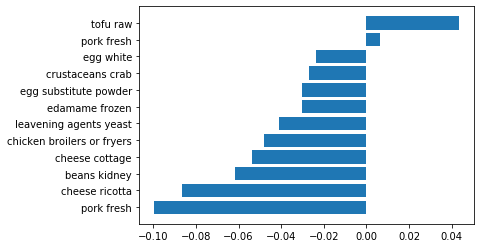

best replacements: ['tofu, raw, regular, prepared with calcium sulfate'
 'pork, fresh, loin, country-style ribs, separable lean only, raw'
 'egg, white, raw, fresh']

Combined and Normalized:


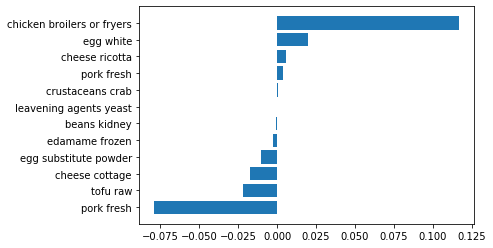

best replacements: ['chicken, broilers or fryers, wing, meat and skin, raw'
 'egg, white, raw, fresh' 'cheese, ricotta, whole milk']

Additive:


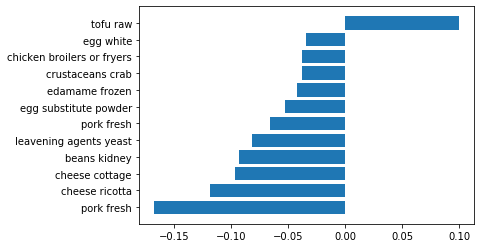

best replacements: ['tofu, raw, regular, prepared with calcium sulfate'
 'egg, white, raw, fresh'
 'chicken, broilers or fryers, wing, meat and skin, raw']


In [16]:
def filter_knn(adj_mat, ingr_signal, maxvals_knn, plot=True, NB_SUGGESTIONS=3):
    """Plot the values of the filtered signal at the indices of its nearest neighbors, as determined by kNN.
    Combine the filter and kNN to determine the best ingredient replacement"""
    x_bp = filter_recipe(ingr_signal, adj_mat)
    best_replacements = ingredient_list[maxvals_knn][x_bp[maxvals_knn].argsort()[-NB_SUGGESTIONS:][::-1]]
    if plot:
        values = x_bp[maxvals_knn]
        sorted_idx = values.argsort()
        x = np.arange(len(values))
        fig, ax = plt.subplots()
        plt.barh(x, values[sorted_idx])
        plt.yticks(x, np.vectorize(first_word)(ingredient_list[maxvals_knn])[sorted_idx])
        plt.show()
    return best_replacements

k = 12
test_recipe = 14
ingr_signal = createIngredientSignal(df, test_recipe, ingredient_list)
ingr_number = np.argwhere(ingredient_list == 'chicken, broiler or fryers, breast, skinless, boneless, meat only, raw')[0,0]
maxvals = suggestKBestReplacements(nutrition_adj_mat, ingr_number, k)

adj_mat = np.load('../data/Adjacency_Matrix_1.npy')
adj_mat = np.delete(adj_mat, ingredients_to_remove, 0)
adj_mat = np.delete(adj_mat, ingredients_to_remove, 1)
print('\nOriginal Adjacency (recipe distance):')
print('best replacements:', filter_knn(adj_mat, ingr_signal, maxvals))
print('\nCombined and Normalized:')
print('best replacements:', filter_knn(adj_mat_norm, ingr_signal, maxvals))
print('\nAdditive:')
print('best replacements:', filter_knn(adj_mat_mean, ingr_signal, maxvals))

Let's try with other recipes!

In [17]:
def test_knn_combo(adj_mat, remove=3, k=12, NB_SUGGESTIONS=4):
    """Test the combination of graph filtering ingredient suggestion and kNN ingredient replacement on several recipes"""
    test_recipes = [14, 19, 39, 60, 82, 103, 24, 600, 8976, 9, 47]
    for tr in test_recipes:
        ingr_signal = createIngredientSignal(df, tr, ingredient_list)
        recipe_name = df.iloc[tr]['title']
        original_ingredients = ingredient_list[ingr_signal > 0]
        print("*** {} ***".format(recipe_name))
        print("Original Ingredients: {}".format(first_word_list(original_ingredients)))
        for i in range(remove):
            ingr_number = np.argwhere(ingredient_list == original_ingredients[i])[0,0]
            maxvals_knn = suggestKBestReplacements(nutrition_adj_mat, ingr_number, k)
            suggested = filter_knn(adj_mat, ingr_signal, maxvals_knn, plot = False, NB_SUGGESTIONS=NB_SUGGESTIONS)
            print("After removing {}: {}".format(first_word(original_ingredients[i]), first_word_list(suggested)))
        print()

test_knn_combo(adj_mat_norm)

*** Broccoli Chicken Casserole Recipe ***
Original Ingredients: broccoli raw, cheese cheddar, chicken broiler or fryers, lemon juice raw, rice white, salad dressing mayonnaise, soup cream of chicken
After removing broccoli raw: onions spring or scallions (includes tops and bulb), brussels sprouts raw, cauliflower raw, lettuce cos or romaine
After removing cheese cheddar: cheese blue, cheese feta, cheese parmesan, cheese neufchatel
After removing chicken broiler or fryers: chicken broilers or fryers, egg white, cheese ricotta, pork fresh

*** Mango Lassi ***
Original Ingredients: mango nectar canned, spices saffron, sugars granulated, water bottled, yogurt greek
After removing mango nectar canned: pineapple raw, apple juice canned or bottled, cranberry juice unsweetened, beverages carbonated
After removing spices saffron: spices basil, spices anise seed, spices poppy seed, spices rosemary
After removing sugars granulated: sweetener syrup, honey, syrup maple, syrups corn

*** Creamy Curr

In [18]:
test_knn_combo(adj_mat_mean)

*** Broccoli Chicken Casserole Recipe ***
Original Ingredients: broccoli raw, cheese cheddar, chicken broiler or fryers, lemon juice raw, rice white, salad dressing mayonnaise, soup cream of chicken
After removing broccoli raw: cauliflower raw, onions spring or scallions (includes tops and bulb), lettuce cos or romaine, fennel bulb
After removing cheese cheddar: cheese parmesan, cheese pasteurized process, cheese neufchatel, cheese gouda
After removing chicken broiler or fryers: tofu raw, egg white, chicken broilers or fryers, crustaceans crab

*** Mango Lassi ***
Original Ingredients: mango nectar canned, spices saffron, sugars granulated, water bottled, yogurt greek
After removing mango nectar canned: pineapple raw, pomegranate juice bottled, cranberry juice unsweetened, pineapple juice canned or bottled
After removing spices saffron: spices cardamom, spices bay leaf, spices fenugreek seed, spices poppy seed
After removing sugars granulated: honey, syrups corn, currants zante, sweete

## Conclusion

Most of the time replacement ingredients are the same "type" of the removed one or plays a similar role in the recipe. Moreover, among the suggested ingredients, most of them are likely to be part of the input recipe.